<a href="https://colab.research.google.com/github/timhak/mech4500/blob/main/Feb_05_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 4 --- P and PI Control

MECH 4500, Lab 4 based on the TCLab.

Try various gains.  Plot and save the results.

Begin by editing Line 201 and Line 202.

Run the code.

Note the table of gains at the bottom of this notebook.

Number of oscillations = 1.       Final error =  0.000025317 degrees C.


'end of simulation'

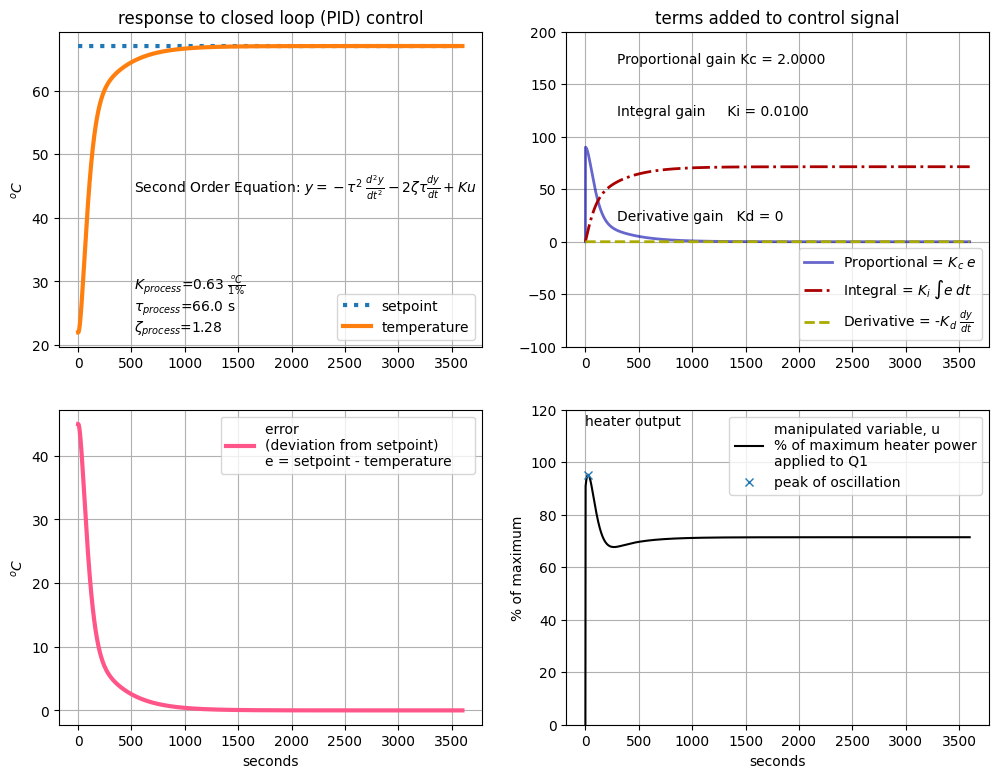

In [1]:
"""
Tune a P, PI, and PID controller.
The system to be controlled is a Temperature Control Lab.

IMPORTANT:  Go to the end of the file.
Change Kc.
Change Ki.
Run.
Save plot.
"""

import numpy as np
from matplotlib.pyplot import *
import scipy.integrate as sci
from scipy.signal import find_peaks

# TC Lab
# next three parameters were experimentally derived from other labs
k= 0.63       # process gain, in 63 degC per 100 percent power
              # units = degC per 1% power
tau=66.0   # time constant in seconds
zeta=1.28  # no units, damping cooefficient

n=3600 # number of seconds for this simulation
t=np.linspace(0,n,n+1)

# reserve a place to store results
r=np.zeros(n+1)
y=np.zeros(n+1)
dydt=np.zeros(n+1)
e=np.zeros(n+1)
prop=np.zeros(n+1)
inte=np.zeros(n+1)
deri=np.zeros(n+1)
feed=np.zeros(n+1)
u=np.zeros(n+1)

T0=22       # ambient initial temperature in degrees C
target=67   # <--- set the desired temperature here

# setpoint values are copied, one for each point in time
sp=target*np.ones_like(t)

# second-order model
# our model can be split into two first-order equations
def tcl(x,t,u):
    y      = x[0]-T0  # diff from quiescient pt

    dydt   = x[1]
    d2ydt2 = (-2*zeta*tau*dydt - y + k*u)/tau**2

    return [dydt,d2ydt2]

def plot_results():
    figure(figsize=(12,9),dpi=100)

    subplot(2,2,1)
    plot(t,sp,':',label='setpoint',lw=3)
    plot(t,y, '-',label='temperature',lw=3)
    legend()
    grid()
    ylabel(r'$^oC$')
    text(520,44,r'Second Order Equation: ' \
     +r'$y=-\tau^2\;\frac{d^2y}{dt^2}-2\zeta\tau\frac{dy}{dt}+K u$')
    s2 = r'$K_{process}$' + f'={k:.2f} ' + r'$\frac{^oC}{1\%}$' + f'\n' \
       + r'$\tau_{process}$'  + f'={tau:.1f} s\n' \
       + r'$\zeta_{process}$' + f'={zeta:.2f}'
    text(520,22,s2)
    title('response to closed loop (PID) control')

    subplot(2,2,2)
    plot(t,Kc*prop,'-' ,color='#00a',lw=2,label=r'Proportional = $K_c\; e$',alpha=0.6)
    plot(t,Ki*inte,'-.',color='#a00',lw=2,label=r'Integral = $K_i\; \int e\; dt$')
    plot(t,Kd*deri,'--',color='#aa0',lw=2,label=r'Derivative = -$K_d\; \frac{dy}{dt} $')
    string=f'Proportional gain Kc = {Kc:0.4f}'; text(300,170,string)
    string=f'Integral gain     Ki = {Ki:0.4f}'; text(300,120,string)
    string=f'Derivative gain   Kd = {Kd:0.3g}'; text(300, 20,string)
    #string=f'Feedforward gain  Kf = {Kf:0.3g}'; text(300,-40,string)
    legend(loc=4)
    grid()
    ylim([-100,200])
    title('terms added to control signal')

    subplot(2,2,3)
    plot(t,e, \
      '#ff5588', \
      lw=3, \
      label=f'error \
      \n(deviation from setpoint) \
      \ne = setpoint - temperature')
    grid()
    legend()
    ylabel(r'$^oC$')
    xlabel('seconds')

    subplot(2,2,4)
    plot(t,u,'#000')
    grid()
    ylabel('% of maximum')
    xlabel('seconds')
    text(0,114,'heater output')
    ylim([0,120])

    (peaks,_)=find_peaks(u,prominence=(1,))
    print(f"Number of oscillations = {len(peaks)}. \
      Final error = {e[-1]: 12.9f} degrees C.")
    plot(peaks,u[peaks],'x')
    legend(['manipulated variable, u' \
        + '\n% of maximum heater power' \
        + '\napplied to Q1','peak of oscillation'])

def run_controller(Kc,Ki,Kd,Kf):
    dt=t[1]-t[0] # time diff between steps
    x0 = [T0,0]  # initial conditions: temperature and dT/dt

    # initial values at very first step 0
    r[0]=sp[0]
    y[0]=T0;y[1]=y[0]
    e[0]=r[0]-y[0]

    # do one loop for each time step, this allows u(t) to vary later
    for i in range(1,n):

        r[i]=sp[i]
        e[i]=r[i]-y[i]

        # PROPORTIONAL
        prop[i]=e[i] # save data for plotting the proportional part

        # INTEGRAL
        inte[i]=inte[i-1] + e[i]*dt
        # limit windup
        if(Ki*inte[i]>100 and Ki!=0.0):
            inte[i]=100/Ki
        if(Ki*inte[i]<0):
            inte[i]=0

        # DERIVATIVE
        # do not use:  dydt[i]=(y[i]-y[i-1])/dt
        # allow dydt to be calculated by odeint below
        # for best accuracy
        deri[i]=-dydt[i]

        # FEEDFORWARD (optional for later)
        feed[i]=r[i]-y[0]

        # ADD THEM TOGETHER:    SIGNAL = P + I + D + FF
        # we now calculate the signal for PID control
        # note:  in LAB 4, please keep Kd and Kf at zero
        # try Kc and Ki adjustments first!
        # MAIN CONTROL EQUATION HERE:
        u[i] = Kc*e[i] + Ki*inte[i] + Kd*deri[i] + Kf*1/k*feed[i]

        # restrict power to remain inside real limits
        if(u[i]>100):
            u[i]=100
        if(u[i]<0):
            u[i]=0

        # Everything is ready to see what happens during the next
        # step in time with the above power value
        # being sent to the heater
        # we now see what the physical laws predict
        # for the next value of T based on current conditions
        # and amount of heat added by this calculated signal.

        # PRELOAD
        # initial values:  T, slope of T
        x0=[y[i],dydt[i]]
        # start and end time for this step of simulation
        tv=[t[i-1],t[i]]

        # GO
        # simulate the results for this step
        ans=sci.odeint(tcl,x0,tv,args=(u[i],))

        # SAVE results for each time step
        y[i+1]=ans[-1,0]     # returns T in column 0, dT/dt in column 1
        dydt[i+1]=ans[-1,1]  # first row is initial condition
                             # last row (last=-1) gives results of this step
    # end of loop through all steps in time

    # CLEANUP by truncating tail end of the array (for prettier plot)
    u[n]=u[n-1]
    e[n]=e[n-1]=e[n-2]
    inte[n]=inte[n-1]

    # RETURN VECTORS OF: system output, PID signal, and error
    return(y,u,e)
    # END of run_controller()

# *** note ***: starr gains fast response are:
Kc=1/k    # proportional gain
Ki=1/tau  # integral gain
Kd=0.0    # derivative gain
Kf=0.0    # feedforward gain

## PUT YOUR TEST VALUES HERE
## ADJUST Kc AND Ki FOR LAB 4

Kc=2.0000
Ki=0.0100
Kd=0.0000
Kf=0.0000

run_controller(Kc,Ki,Kd,Kf)
plot_results()
'end of simulation'

Here is a table of gains to try:

|Trial|Kc|Ki|
|---:|---:|---:|
|1|1.00|0.0000|
|2|1000|0.0000|
|3|2.00|0.0000|
|4|0.00|1.0000|
|5|0.00|0.0001|
|6|0.00|0.0100|
|7|2.00|0.0100|
|* 8|1.59|0.0152|
|9|your own Kc|your own Ki|

> \* [Starr gains, YouTube: Control Tuning, Ch.5; min:sec = 20:43](https://youtu.be/m_LhFFfuKfo?list=PLOgEb39vsYlsZGdZV-aYeaH4gxYVXxsuw&t=1243)
